# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import os
import io
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline


In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

# Exploring the portfolio dataframe

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


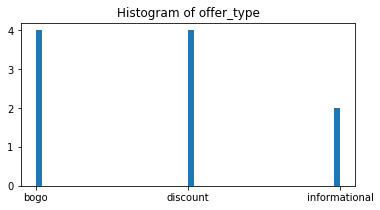

In [6]:
plt_list=['offer_type']
n_bins = 50 # can decrease to get a wider bin (or vice versa)
for column_name in plt_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(portfolio[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

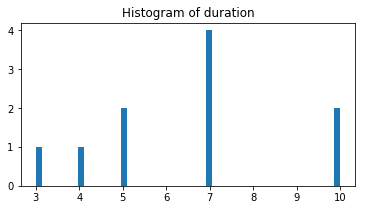

In [7]:
plt_list=['duration']
n_bins = 50 # can decrease to get a wider bin (or vice versa)
for column_name in plt_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(portfolio[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

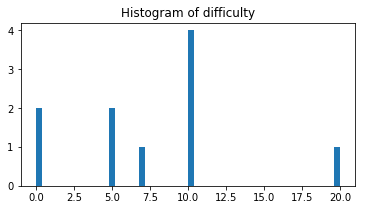

In [8]:
plt_list=['difficulty']
n_bins = 50 # can decrease to get a wider bin (or vice versa)
for column_name in plt_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(portfolio[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

# Exploring the profile dataframe

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
print('(orig) rows,cols:',profile.shape)


(orig) rows,cols: (17000, 5)


In [11]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Distribution of age in the profile dataframe

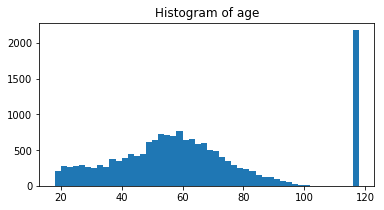

In [14]:
plt_list=['age']
n_bins = 50 # can decrease to get a wider bin (or vice versa)
for column_name in plt_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(profile[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

Distribution of gender in the profile dataframe

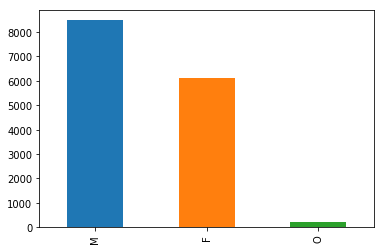

In [15]:
plt.figure(figsize=(6,3))
fig, ax = plt.subplots()    
y_counts = profile['gender'].value_counts()
y_counts.plot(kind='bar')

Text(0.5,1,'Gender distribution')

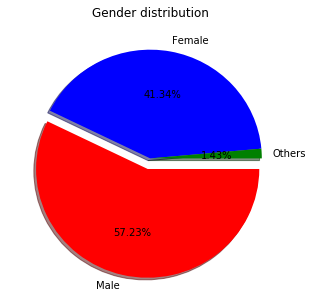

In [16]:
plt.figure(figsize=[5, 5])
pltValues = profile['gender'].value_counts()
colors = ['red','blue','green']
labels = ['Male','Female','Others']
explode = (0.1,0,0)
plt.pie(pltValues, colors=colors, labels=labels, explode=explode, autopct='%1.2f%%', counterclock=False, shadow=True)
plt.title('Gender distribution')

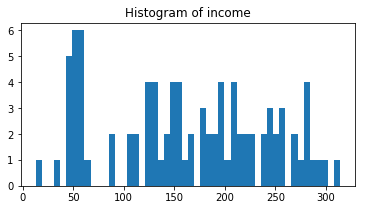

In [17]:
plt_list=['income']
n_bins = 50 # can decrease to get a wider bin (or vice versa)
for column_name in plt_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(profile[column_name].value_counts(), bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

# Exploring the transcript dataframe

In [18]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [19]:
print('(orig) rows,cols:',transcript.shape)

(orig) rows,cols: (306534, 4)


In [20]:
transcript.describe(include="all")

,event,person,time,value
count,306534,306534,306534.000000,306534
unique,4,17000,NaN,5121
top,transaction,94de646f7b6041228ca7dec82adb97d2,NaN,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,138953,51,NaN,14983
mean,NaN,NaN,366.382940,NaN
std,NaN,NaN,200.326314,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,186.000000,NaN
50%,NaN,NaN,408.000000,NaN
75%,NaN,NaN,528.000000,NaN


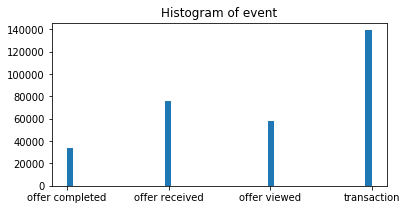

In [21]:
plt_list=['event']
n_bins = 50 # can decrease to get a wider bin (or vice versa)
for column_name in plt_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(transcript[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

# Data preaparation and cleaning

# Cleaning portfolio

Rename the columns difficulty to offer_difficulty,id to offer_id,duration to offer_duaration and reward to offer_reward.
Encode the channels column.
Encode the offer_types column.



In [22]:
portfolio=portfolio.rename(columns={'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'})

In [23]:
portfolio['email'] = [1 if 'email' in x else 0 for x in portfolio['channels']] 
portfolio['mobile'] = [1 if 'mobile' in x else 0 for x in portfolio['channels']]
portfolio['social'] = [1 if 'social' in x else 0 for x in portfolio['channels']]
portfolio['web'] = [1 if 'web' in x else 0 for x in portfolio['channels']]
portfolio=portfolio.drop(columns='channels')
portfolio['bogo']=[1 if 'bogo' in x else 0 for x in portfolio['offer_type']]
portfolio['discount']=[1 if 'discount' in x else 0 for x in portfolio['offer_type']]
portfolio['informational']=[1 if 'informational' in x else 0 for x in portfolio['offer_type']]

In [24]:
portfolio.head()

,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


# Cleaning Profile

Rename the columns id to customer_id, income to customer_income
Encode the age column into buckets by decade(10-20, 20-30, 30-40 and so on).
Encode the gender column.
Store the year the customer became a member on.

In [25]:
profile=profile.rename(columns={'id':'customer_id' , 'income':'customer_income'})

In [26]:
profile.replace(118, np.nan , inplace=True)
profile['age'] = profile['age'].fillna(profile['age'].mean())
profile['customer_income'] = profile['customer_income'].fillna(profile['customer_income'].mean())
mode = profile['gender'].mode()[0]
profile['gender'] = profile['gender'].fillna(mode)
profile= profile[profile['age'] <= 80]
profile['age'] = profile['age'].astype(int)

In [27]:
profile['membership_year']=profile['became_member_on'].astype(str).str[0:4]
profile['age[10-20]'] = [1 if x>=10 and x<20 else 0 for x in profile['age']] 
profile['age[20-30]'] = [1 if x>=20 and x<30 else 0 for x in profile['age']] 
profile['age[30-40]'] = [1 if x>=30 and x<40 else 0 for x in profile['age']] 
profile['age[40-50]'] = [1 if x>=40 and x<50 else 0 for x in profile['age']] 
profile['age[50-60]'] = [1 if x>=50 and x<60 else 0 for x in profile['age']] 
profile['age[60-70]'] = [1 if x>=60 and x<70 else 0 for x in profile['age']] 
profile['age[70-80]'] = [1 if x>=70 and x<80 else 0 for x in profile['age']] 
profile['age[80-90]'] = [1 if x>=80 and x<90 else 0 for x in profile['age']] 
profile['age[90-100]'] = [1 if x>=90 and x<100 else 0 for x in profile['age']] 
profile['age[100-110]'] = [1 if x>=100 and x<=110 else 0 for x in profile['age']] 
profile['gender_F']=[1 if x=='F' else 0 for x in profile['gender']]
profile['gender_M']=[1 if x=='M' else 0 for x in profile['gender']]
profile['gender_O']=[1 if x=='O' else 0 for x in profile['gender']]
profile=profile.drop(columns='age')

In [28]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 18 columns):
became_member_on    16014 non-null int64
gender              16014 non-null object
customer_id         16014 non-null object
customer_income     16014 non-null float64
membership_year     16014 non-null object
age[10-20]          16014 non-null int64
age[20-30]          16014 non-null int64
age[30-40]          16014 non-null int64
age[40-50]          16014 non-null int64
age[50-60]          16014 non-null int64
age[60-70]          16014 non-null int64
age[70-80]          16014 non-null int64
age[80-90]          16014 non-null int64
age[90-100]         16014 non-null int64
age[100-110]        16014 non-null int64
gender_F            16014 non-null int64
gender_M            16014 non-null int64
gender_O            16014 non-null int64
dtypes: float64(1), int64(14), object(3)
memory usage: 2.3+ MB


In [29]:
profile.head()

,became_member_on,gender,customer_id,customer_income,membership_year,age[10-20],age[20-30],age[30-40],age[40-50],age[50-60],age[60-70],age[70-80],age[80-90],age[90-100],age[100-110],gender_F,gender_M,gender_O
0,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,0,0,0,0,1,0,0,0,0,0,0,1,0
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,0,0,0,0,1,0,0,0,0,0,1,0,0
2,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,0,0,0,0,1,0,0,0,0,0,0,1,0
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,0,0,0,0,0,0,1,0,0,0,1,0,0
4,20170804,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,0,0,0,0,1,0,0,0,0,0,0,1,0


# Cleaning transcript

Rename person to customer_id.
Encode events.
Get ‘offer id’ from value column dictionary and place in new column clean_id.
Get ‘amount’ from value column dictionary and place in new column money_spent.

In [30]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript['offer_viewed'] = [1 if x=='offer viewed' else 0 for x in transcript['event']]
transcript['offer_received'] = [1 if x=='offer received' else 0 for x in transcript['event']]
transcript['offer_completed'] = [1 if x=='offer completed' else 0 for x in transcript['event']]
for x in transcript['event']:
    if x=='offer received':
        transcript['event']=1
    elif x=='offer viewed':
        transcript['event']=2
    elif x=='offer completed':
        transcript['event']=3   
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward,offer_viewed,offer_received,offer_completed
0,3,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,0,1,0
1,3,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,0,1,0
2,3,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,0,1,0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,0,1,0
4,3,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN,0,1,0


In [31]:
transcript['money_gained']=transcript['value'].apply(lambda key: key.get('reward'))
transcript['money_spent']=transcript['value'].apply(lambda key: key.get('amount'))
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])
transcript.drop(['offer id', 'offer_id','value'], axis=1, inplace=True)
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)
transcript.fillna(0 , inplace=True)
transcript=transcript.drop(columns='amount')
transcript=transcript.drop(columns='reward')

In [32]:
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [33]:
transcript.head()

,event,customer_id,time,offer_viewed,offer_received,offer_completed,money_gained,money_spent,offer_id
0,3,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,3,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,3,e2127556f4f64592b11af22de27a7932,0,0,1,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,3,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [34]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
event              306534 non-null int64
customer_id        306534 non-null object
time               306534 non-null int64
offer_viewed       306534 non-null int64
offer_received     306534 non-null int64
offer_completed    306534 non-null int64
money_gained       306534 non-null float64
money_spent        306534 non-null float64
offer_id           306534 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 21.0+ MB


In [35]:
transcript.offer_id.nunique()

11

In [36]:
transcript.customer_id.nunique()

17000

# Exploratory data analysis

# Merging of data frames

In [38]:
temp = pd.merge(transcript,portfolio,how='left',on='offer_id')
temp.head()

,event,customer_id,time,offer_viewed,offer_received,offer_completed,money_gained,money_spent,offer_id,offer_difficulty,offer_duration,offer_type,offer_reward,email,mobile,social,web,bogo,discount,informational
0,3,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,3,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3,e2127556f4f64592b11af22de27a7932,0,0,1,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,3,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [39]:
merged_data=pd.merge(temp,profile,how='left',on='customer_id')
merged_data.head()

,event,customer_id,time,offer_viewed,offer_received,offer_completed,money_gained,money_spent,offer_id,offer_difficulty,...,age[40-50],age[50-60],age[60-70],age[70-80],age[80-90],age[90-100],age[100-110],gender_F,gender_M,gender_O
0,3,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,e2127556f4f64592b11af22de27a7932,0,0,1,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,10.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,10.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
merged_data=merged_data.dropna(axis=0)

In [41]:
merged_data.shape

(157503, 37)

In [42]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 306527
Data columns (total 37 columns):
event               157503 non-null int64
customer_id         157503 non-null object
time                157503 non-null int64
offer_viewed        157503 non-null int64
offer_received      157503 non-null int64
offer_completed     157503 non-null int64
money_gained        157503 non-null float64
money_spent         157503 non-null float64
offer_id            157503 non-null object
offer_difficulty    157503 non-null float64
offer_duration      157503 non-null float64
offer_type          157503 non-null object
offer_reward        157503 non-null float64
email               157503 non-null float64
mobile              157503 non-null float64
social              157503 non-null float64
web                 157503 non-null float64
bogo                157503 non-null float64
discount            157503 non-null float64
informational       157503 non-null float64
became_member_on    15

In [43]:
merged_data.columns

Index(['event', 'customer_id', 'time', 'offer_viewed', 'offer_received',
       'offer_completed', 'money_gained', 'money_spent', 'offer_id',
       'offer_difficulty', 'offer_duration', 'offer_type', 'offer_reward',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'became_member_on', 'gender', 'customer_income', 'membership_year',
       'age[10-20]', 'age[20-30]', 'age[30-40]', 'age[40-50]', 'age[50-60]',
       'age[60-70]', 'age[70-80]', 'age[80-90]', 'age[90-100]', 'age[100-110]',
       'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

Distribution of events in merged dataFrame and 
Distribution of ages in merged dataframe

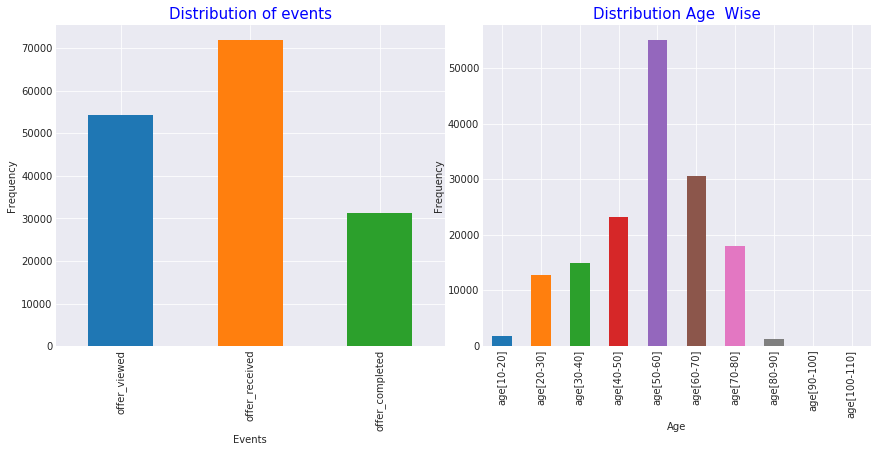

In [44]:
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,2,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()

merged_data[merged_data.columns[3:6]].sum().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Distribution of events", fontsize=15,color='blue')
ax[0].set_xlabel("Events", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)



merged_data[merged_data.columns[24:34]].sum().plot.bar(ax=ax[1],fontsize=10) 
ax[1].set_title("Distribution Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)




Distribution of channels in merged dataFrame and 
Distribution of offer_types in merged dataframe

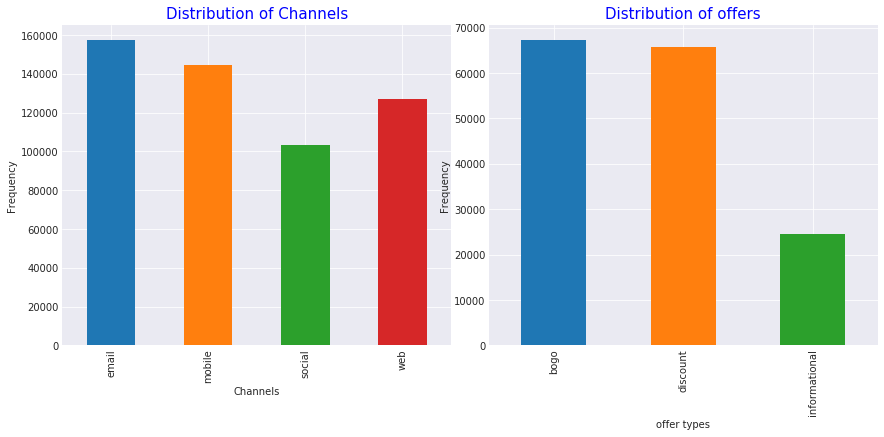

In [45]:
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,2,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()

merged_data[merged_data.columns[13:17]].sum().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Distribution of Channels", fontsize=15,color='blue')
ax[0].set_xlabel("Channels", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)



merged_data[merged_data.columns[17:20]].sum().plot.bar(ax=ax[1],fontsize=10) 
ax[1].set_title("Distribution of offers", fontsize=15,color='blue')
ax[1].set_xlabel("offer types", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)



Distribution of gender

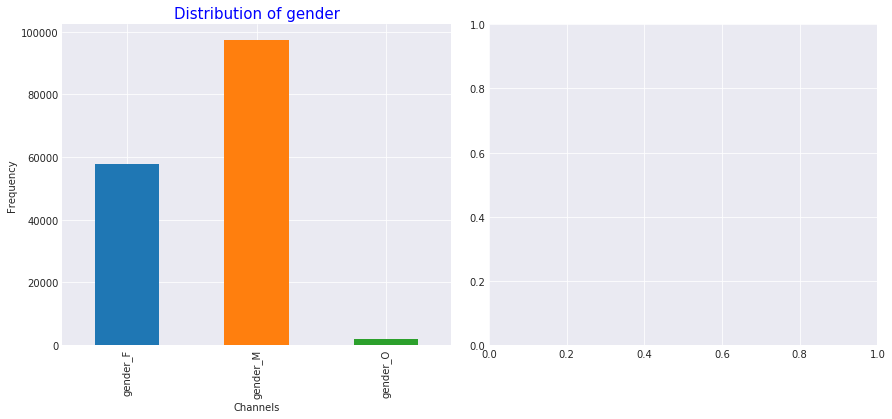

In [46]:
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,2,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()

merged_data[merged_data.columns[34:]].sum().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Distribution of gender", fontsize=15,color='blue')
ax[0].set_xlabel("Channels", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# Machine Learning Model to predict response of a customer to an offer

In [47]:
plot_gender = merged_data[merged_data['gender'] != 'O']
merged_data=merged_data.drop(columns='gender')
offer_types=merged_data[merged_data['offer_type']!='some']
merged_data=merged_data.drop(columns='offer_type')

Scale and normalize numerical data

In [48]:
offerids = merged_data['offer_id'].unique().tolist()
o_mapping = dict( zip(offerids,range(len(offerids))) )
merged_data.replace({'offer_id': o_mapping},inplace=True)
    
cusids = merged_data['customer_id'].unique().tolist()
c_mapping = dict( zip(cusids,range(len(cusids))) )
merged_data.replace({'customer_id': c_mapping},inplace=True)
    
scaler = MinMaxScaler() 
numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
merged_data[numerical] = scaler.fit_transform(merged_data[numerical].astype(float))

In [49]:
merged_data[['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']].head(10)

,customer_income,offer_difficulty,offer_duration,offer_reward,time,money_gained,money_spent
0,0.777778,0.25,0.571429,0.5,0.0,0.0,0.0
1,0.393389,1.00,1.000000,0.5,0.0,0.0,0.0
2,0.444444,0.50,0.571429,0.2,0.0,0.0,0.0
3,0.393389,0.50,1.000000,0.2,0.0,0.0,0.0
4,0.393389,0.50,0.285714,1.0,0.0,0.0,0.0
5,0.255556,0.25,0.285714,0.5,0.0,0.0,0.0
6,0.393389,0.35,0.571429,0.3,0.0,0.0,0.0
7,0.233333,0.00,0.142857,0.0,0.0,0.0,0.0
8,0.300000,1.00,1.000000,0.5,0.0,0.0,0.0
9,0.455556,1.00,1.000000,0.5,0.0,0.0,0.0


In [50]:
merged_data.offer_completed.value_counts()

0    126259
1     31244
Name: offer_completed, dtype: int64

In [51]:
merged_data.offer_received.value_counts()

0    85640
1    71863
Name: offer_received, dtype: int64

In [52]:
merged_data.offer_viewed.value_counts()

0    103107
1     54396
Name: offer_viewed, dtype: int64

In [53]:
data = merged_data.drop('event', axis=1)
label = merged_data['event']

# Split train and test data

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 94501 rows
Testing set: 63002 rows


In [55]:
X_test.head(10)

,customer_id,time,offer_viewed,offer_received,offer_completed,money_gained,money_spent,offer_id,offer_difficulty,offer_duration,...,age[40-50],age[50-60],age[60-70],age[70-80],age[80-90],age[90-100],age[100-110],gender_F,gender_M,gender_O
131436,13851,0.487395,1,0,0,0.0,0.0,6,0.35,0.571429,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15527,10376,0.000000,1,0,0,0.0,0.0,6,0.35,0.571429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
184350,13745,0.621849,0,0,1,1.0,0.0,8,0.50,0.571429,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
299337,15029,0.957983,0,0,1,0.2,0.0,2,0.50,0.571429,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
193870,13005,0.663866,0,0,1,0.5,0.0,5,0.25,0.285714,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
63701,9884,0.235294,0,1,0,0.0,0.0,7,0.00,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
163093,11656,0.571429,0,1,0,0.0,0.0,0,0.25,0.571429,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
279506,36,0.865546,0,0,1,0.5,0.0,1,1.00,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
269727,3474,0.831933,0,0,1,0.2,0.0,3,0.50,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
220796,8037,0.714286,1,0,0,0.0,0.0,7,0.00,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Traning and Testing

# Metrics
We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [56]:
def train_test(clf):
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

KNeighborsClassifier

In [57]:
clf_A = KNeighborsClassifier(n_neighbors = 3)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [58]:
knn={'Benchmark Model' : [a_model],'train F1 score': [a_train_f1], 'test F1 score' : [a_test_f1]}
benchmark=pd.DataFrame(knn)

In [59]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,100.0,100.0


RandomForestClassifier

In [60]:
clf_B = RandomForestClassifier(random_state =5)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

In [61]:
clf_C = DecisionTreeClassifier(random_state = 5)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

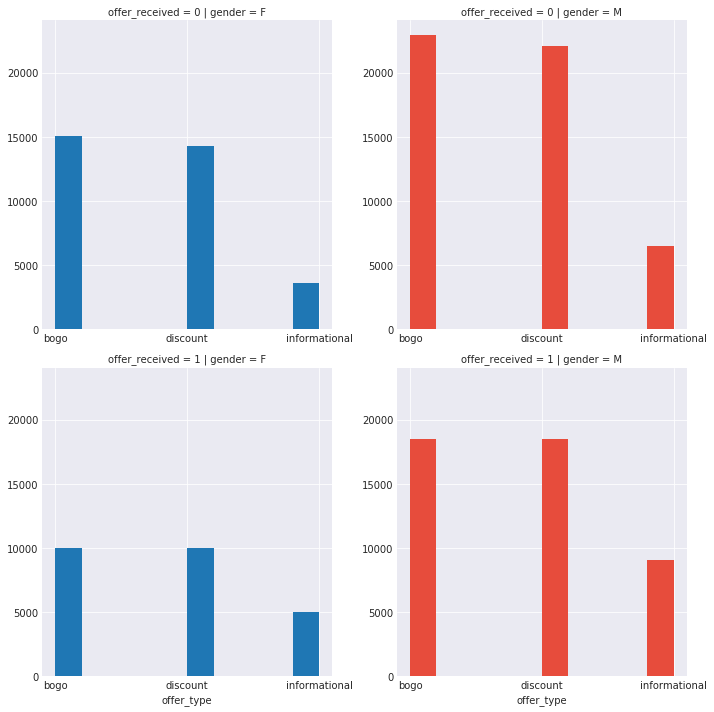

In [62]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(plot_gender, row='offer_received', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

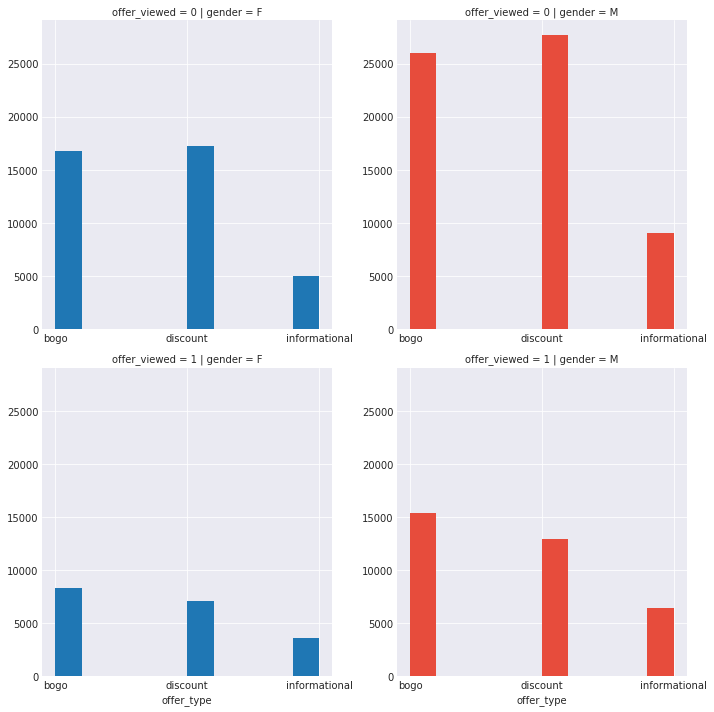

In [63]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(plot_gender, row='offer_viewed', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

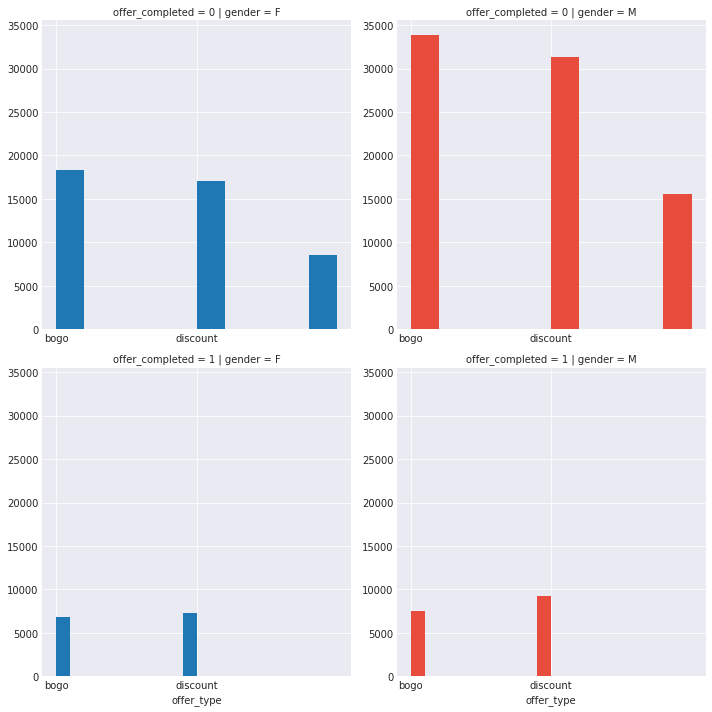

In [64]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(plot_gender, row='offer_completed', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

The males represent 57.23 percent,female represent 41.34 percent and others reprsent 1.43 percent.The people of age 50-60 use the app most.Discount offers are more preferred by the customers.There are less number of people who complete the offers compared to the people who view and ignore it.

# Model Comparisions

In [65]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)

In [66]:
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),100.0,100.0
1,RandomForestClassifier,100.0,100.0
2,DecisionTreeClassifier,100.0,100.0
